# Volume 3: Intro to Deep Learning
    Matthew Mella

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Load the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0, 0.0, 0.0),
                                                     (1.0, 1.0, 1.0))])

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
           )

# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [5]:
actual_train_data = [train_data[i] for i in range(40_000)]
validate_data = [train_data[i] for i in range(40_000, 50_000)]
test_data = [test_data[i] for i in range(len(test_data))]

# Create a DataLoader from the shuffled training data
train_loader = DataLoader(actual_train_data, batch_size=36, shuffle=True)
validate_loader = DataLoader(validate_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Be sure that your final activation function is the softmax function.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [14]:
class CNN(nn.Module):
    def __init__(self):
        # Initialize nn.Module
        super().__init__()
        # Create parameter-free layers
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Create convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=4, padding=1)

        # Create linear layers
        self.linear1 = nn.Linear(in_features=294, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)

    def forward(self, x):
        # Apply layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch. 
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients 
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop 
    - Backpropagate to compute gradients 
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

  0%|          | 0/1112 [00:18<?, ?it/s]
epoch:9, loss:1.1257: : 11120it [02:50, 65.06it/s]                       


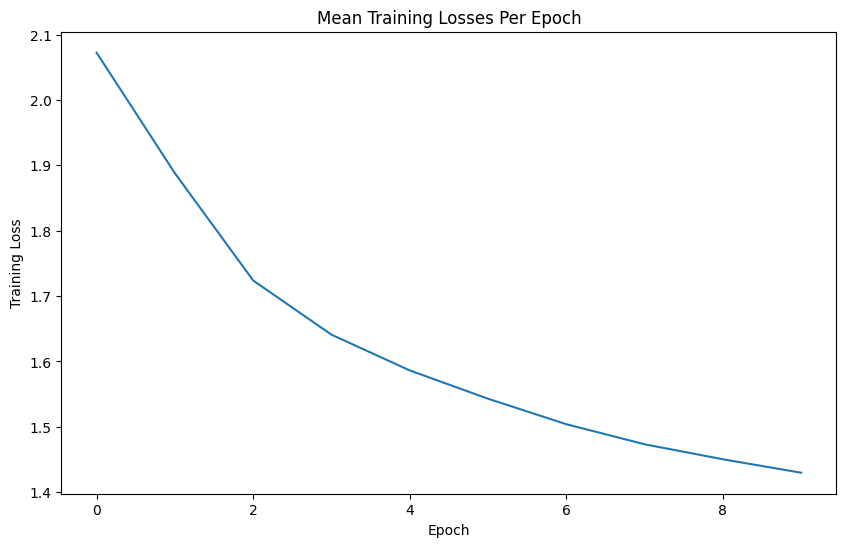

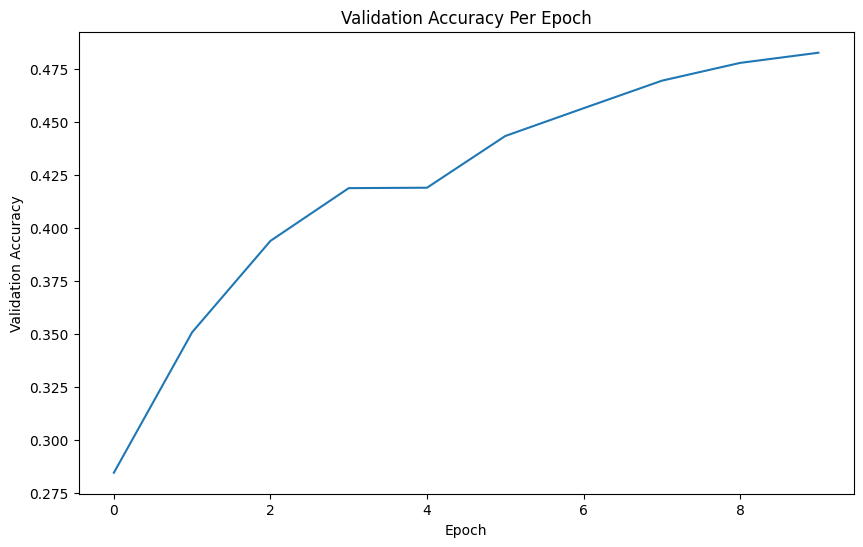

Test accuracy: 0.4835


In [15]:
# Create model, objective, optimizer, and number of epochs
model = CNN()
model.to(device)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# Instantiate tqdm loop and initialize lists to store losses and validation accuracies
loop = tqdm(total=len(train_loader), position=0)
mean_losses = []
validation_accuracies = []

# Train model
for epoch in range(num_epochs):

    # Set model to train mode
    model.train()

    # Initialize list to store losses
    loss_list = []

    # Iterate over training data
    for x, y_truth in train_loader:

        # Move data to device
        x, y_truth = x.to(device), y_truth.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Predict and calculate loss
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        loss_list.append(loss.item())

        # Update tqdm loop
        loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
        loop.update()

        # Backpropagate and update weights
        loss.backward()
        optimizer.step()

    # Calculate mean loss
    loss_mean = np.array(loss_list).mean()

    # Validate model
    model.eval()
    validation_score = 0
    for x, y_truth in validate_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        if y_truth == y_hat.argmax(1):  # compare with greatest probability
            validation_score += 1
    validation_accuracy = validation_score / len(validate_loader)

    # Store mean loss and validation accuracy
    mean_losses.append(loss_mean)
    validation_accuracies.append(validation_accuracy)
loop.close()

# Plot mean losses and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(mean_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Mean Training Losses Per Epoch')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(validation_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Per Epoch')
plt.show()

# Test model
model.eval()
test_score = 0
for x, y_truth in test_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    y_hat = model(x)
    if y_truth == y_hat.argmax(1):  # compare with greatest probability
        test_score += 1
test_accuracy = test_score / len(test_loader)
print('Test accuracy:', test_accuracy)

# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [8]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

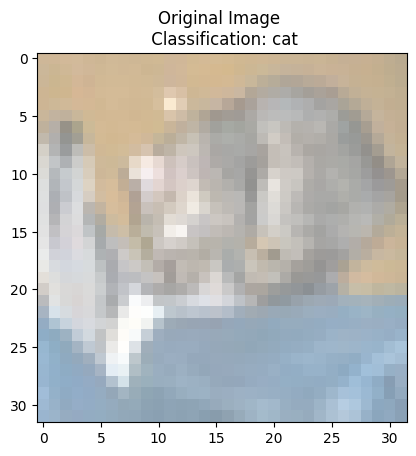

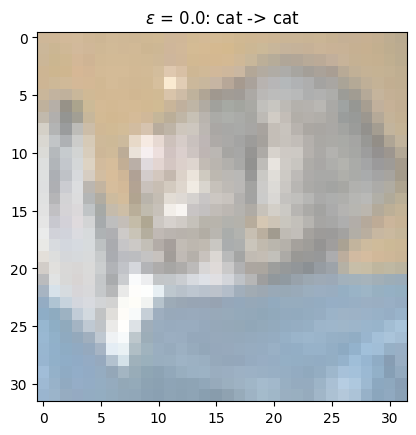

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.0: 0.4835


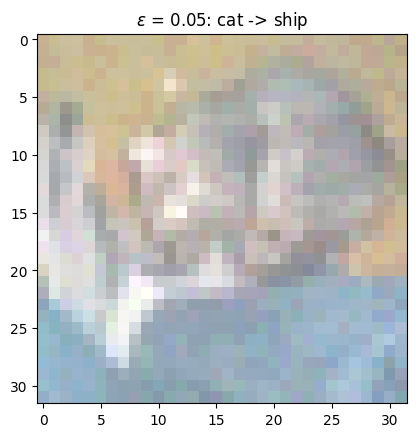

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.05: 0.0331


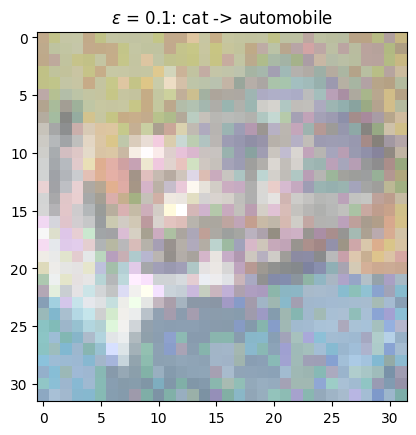

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.1: 0.0047


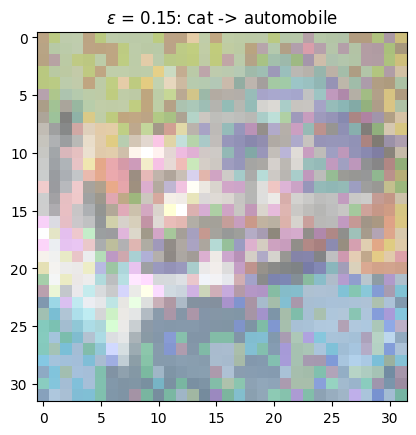

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.15: 0.0014


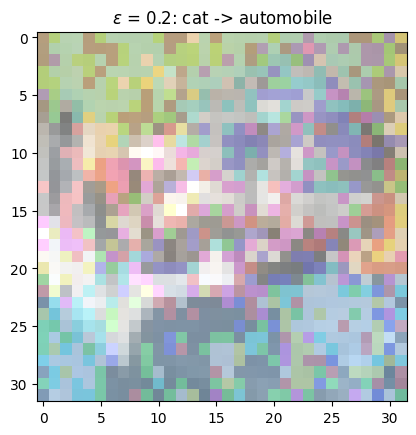

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.2: 0.0005


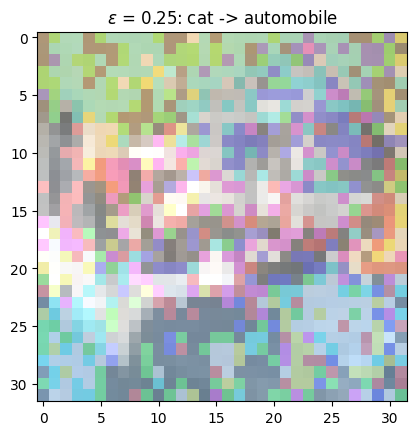

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy with eps=0.25: 0.0003


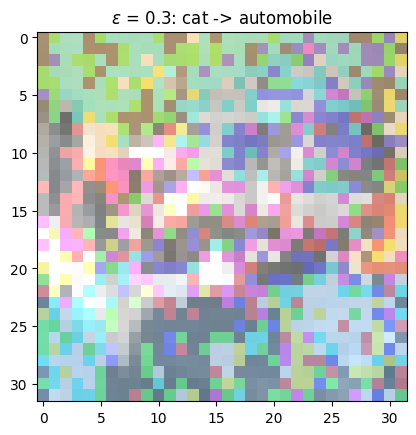

Test accuracy with eps=0.3: 0.0002


In [16]:
eps = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Get the label names
label_names = train_data.classes

# Set the model to evaluation mode
model.eval()

# Predict the first image in the test set
x, y_truth = next(iter(test_loader))
x, y_truth = x.to(device), y_truth.to(device)
y_hat = model(x)

first_classified = label_names[y_hat.argmax(1).item()]

# Plot the first image
ex = x.cpu().detach().numpy()[0]
img = ex / 2 + 0.5
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(f'Original Image \n Classification: {first_classified}')
plt.show()

for eps in eps:
    test_score = 0
    i = 0
    for x, y_truth in test_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        x_perturbed = fgsm_attack(model, optimizer, objective, x, y_truth, eps)
        y_hat = model(x_perturbed)
        if i == 0:
            ex = x_perturbed.cpu().detach().numpy()[0]
            img = ex / 2 + 0.5
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.title(fr'$\epsilon$ = {eps}: {first_classified} -> {label_names[y_hat.argmax(1).item()]}')
            plt.show()
        i += 1
        if y_truth == y_hat.argmax(1):  # compare with greatest probability
            test_score += 1
    test_accuracy = test_score / len(test_loader)
    print('Test accuracy with eps={}:'.format(eps), test_accuracy)

